# Raw Data Preprocessing

Data is collected in CSV format from Androsensor. The data contains the readings from the gyroscope and accelerometer interia sensors when performing a task.

https://medium.com/analytics-vidhya/exploring-data-acquisition-and-trajectory-tracking-with-android-devices-and-python-9fdef38f25ee

In [22]:
import pandas as pd
import numpy as np 
from scipy.integrate import cumtrapz
from numpy import sin,cos,pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

plt.style.use('seaborn')

Importing data from CSV and checking sensor outputs via graphical representation

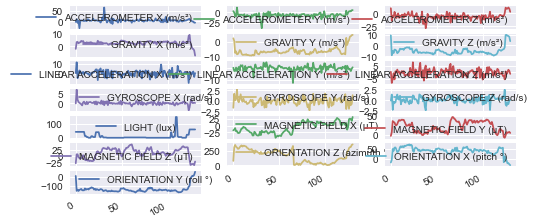

In [23]:
data = pd.read_csv('Androsensor/cycling2.csv')

data.plot(subplots = True, sharex = True, layout = (10, 3))
plt.show()

# Transforming the X,Y,Z Accelerations 

Three types of acceleration were recorded: gravity acceleration, linear acceleration and total acceleration. 
Gravity acceleration is the force of gravity acting on the phone. 
Linear acceleration is due to the external forces acting on the phone; ie: the phone moving physically on the X,Y,Z plane
Total acceleration is the sum of Gravity acceleration and Linear acceleration.

But since the recordings were not recorded considering the earth frame, a 3D rotation transformation. The transformation is done with matrix algebra.

In [24]:
#Transforming Body Frame Accelerations into the Inertial frame 
    #Setting up the Rotation Matrices 

def rotationX(x):
    return np.array([[1, 0, 0],
                    [0, cos(-x), -sin(-x)],
                    [0, sin(-x), cos(-x)]])

def rotationY(y):
    return np.array([[cos(-y), 0, -sin(-y)],
                    [0, 1, 0],
                    [sin(-y), 0, cos(-y)]])

def rotationZ(z):
    return np.array([[cos(-z), -sin(-z), 0],
                    [sin(-z), cos(-z), 0],
                    [0, 0, 1]])

In [25]:
# Set up arrays to hold acceleration data for transformation
accel = np.array([data['ACCELEROMETER X (m/s²)'],
                  data['ACCELEROMETER Y (m/s²)'],
                  data['ACCELEROMETER Z (m/s²)']])

grav = np.array([data['GRAVITY X (m/s²)'],
                 data['GRAVITY Y (m/s²)'],
                 data['GRAVITY Z (m/s²)']])

line = np.array([data['LINEAR ACCELERATION X (m/s²)'],
                 data['LINEAR ACCELERATION Y (m/s²)'],
                 data['LINEAR ACCELERATION Z (m/s²)']])

In [26]:
#Set up arrays to hold Euler angles for Rotation Matrices
pitch = data['ORIENTATION X (pitch °)']
roll = data['ORIENTATION Y (roll °)']
yaw = data['ORIENTATION Z (azimuth °)']

In [27]:
#Initialize arrays for new transformed accelerations
total = np.empty(accel.shape)
gravity = np.empty(accel.shape)
linear = np.empty(accel.shape)

In [28]:
#Frame Transformations (Body Frame --> Earth Frame)
for i in range(data.shape[0]):
    
    total[:, i] = rotationZ(yaw[i]) @ rotationY(roll[i]) @ rotationX(pitch[i]) @ accel[:, i]
    gravity[:, i] = rotationZ(yaw[i]) @ rotationY(roll[i]) @ rotationX(pitch[i]) @ grav[:, i]
    linear[:, i] = rotationZ(yaw[i]) @ rotationY(roll[i]) @ rotationX(pitch[i]) @ line[:, i]

In [29]:
# Create new columns in dataframe for earth frame accelerations    
data['EARTH ACCELERATION X'] = total[0,:]
data['EARTH ACCELERATION Y'] = total[1,:]
data['EARTH ACCELERATION Z'] = total[2,:]

data['EARTH GRAVITY X'] = gravity[0,:]
data['EARTH GRAVITY Y'] = gravity[1,:]
data['EARTH GRAVITY Z'] = gravity[2,:]

data['EARTH LINEAR ACCELERATION X'] = linear[0,:]
data['EARTH LINEAR ACCELERATION Y'] = linear[1,:]
data['EARTH LINEAR ACCELERATION Z'] = linear[2,:]

C:\Users\owena\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:189: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
C:\Users\owena\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


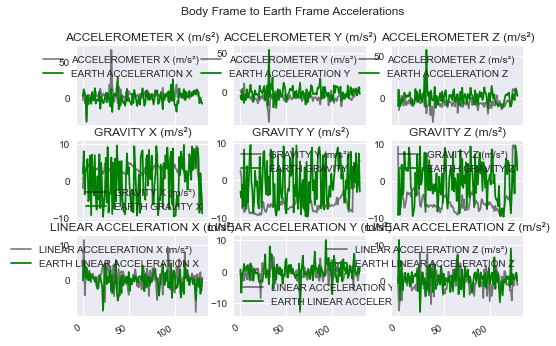

In [30]:
#Plotting the New Accelerations
cols_earth = ['EARTH ACCELERATION X','EARTH ACCELERATION Y',
              'EARTH ACCELERATION Z','EARTH GRAVITY X','EARTH GRAVITY Y','EARTH GRAVITY Z',
              'EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']

cols_body = ['ACCELEROMETER X (m/s²)','ACCELEROMETER Y (m/s²)',
             'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)','GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
             'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)']

bodyplot = data.plot(y=cols_body,subplots=True,sharex=True,layout=(3,3),style='k',alpha=0.5,title=cols_body)

data.plot(y=cols_earth,subplots=True,layout=(3,3),ax=bodyplot, sharex=True,style='g', title='Body Frame to Earth Frame Accelerations')

plt.show()

# Double Integration

This is to calculate the phone's motion by integrating the linear accelerations

In [40]:
dt = np.log(0.01) #Nahseb this value has to be fixed imma works

x =cumtrapz(cumtrapz(data['EARTH LINEAR ACCELERATION X'] ,dx=dt) ,dx=dt)
y =cumtrapz(cumtrapz(data['EARTH LINEAR ACCELERATION Y'] ,dx=dt) ,dx=dt)
z =cumtrapz(cumtrapz(data['EARTH LINEAR ACCELERATION Z'] ,dx=dt) ,dx=dt)

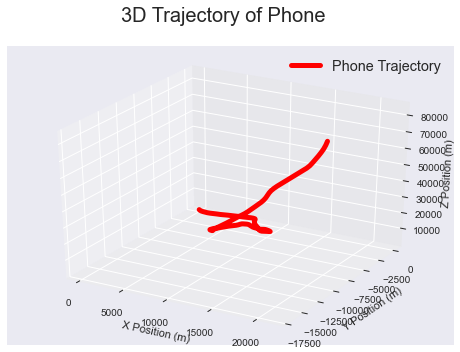

In [41]:
#Plotting the 3D Trajectory 
figure, ax = plt.subplots()
figure.suptitle('3D Trajectory of Phone', fontsize = 20)

ax = plt.axes(projection='3d')
ax.plot3D(x,y,z, c= 'red', lw= 5, label= 'Phone Trajectory')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')

ax.legend(fontsize='x-large')
plt.show()

# Performing Fourier Analysis on Acceleration

When the accelerations were integrated, the noise collected by the accelerometer was integrated as well. Therefore, to determine a cutoff frequency which differentiates the accelerations from the noise, a Fourier analysis of the noise spectrum was carried out

In [42]:
#Discrete Fourier Transform sample frequencies 
freq = np.fft.rfftfreq(data['EARTH LINEAR ACCELERATION X'].size, d=dt)

#Compute the FFT of Acceleration Signals
fftX = np.fft.rfft(data['EARTH LINEAR ACCELERATION X'])
fftY = np.fft.rfft(data['EARTH LINEAR ACCELERATION Y'])
fftZ = np.fft.rfft(data['EARTH LINEAR ACCELERATION Z'])

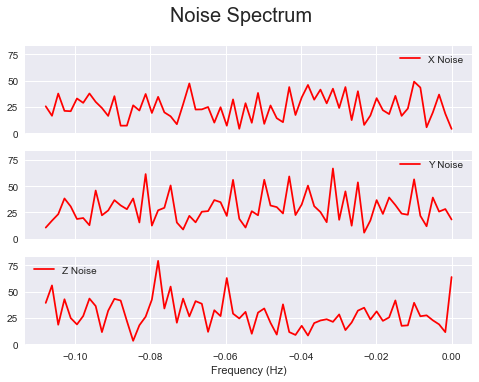

In [44]:
#Plotting the Frequency Spectrum 
freqfig, [ax1,ax2,ax3] = plt.subplots(3, 1, sharex= True, sharey= True)
freqfig.suptitle('Noise Spectrum', fontsize=20)

ax1.plot(freq,abs(fftX), c='r', label = 'X Noise')
ax1.legend()

ax2.plot(freq,abs(fftY), c='r', label = 'Y Noise')
ax2.legend()

ax3.plot(freq,abs(fftZ), c='r', label = 'Z Noise')
ax3.legend()
ax3.set_xlabel('Frequency (Hz)')

plt.show()

Creating a High Pass Filter to Attenuate Low Frequency Noise

In [45]:
#Attenuate Noise in X,Y below 10Hz by 10 dB or multiply by 0.1
#Attenuate Noise in Z where > 5Hz and < 10 Hz by the same rate

attenFFTX = np.where(freq < 10, fftX*0.1, fftX)
attenFFTY = np.where(freq < 10, fftY*0.1, fftY)
attenFFTZ = np.where((freq > 5)&(freq < 10), fftZ*0.1, fftZ)

#Compute Inverse Discrete Fourier Transform
data['x_ifft'] = np.fft.irfft(attenFFTX, n=data.shape[0])
data['y_ifft'] = np.fft.irfft(attenFFTY, n=data.shape[0])
data['z_ifft'] = np.fft.irfft(attenFFTZ, n=data.shape[0])

In [49]:
#Plotting new Signals

rawCols = ['EARTH LINEAR ACCELERATION X', 'EARTH LINEAR ACCELERATION Y', 'EARTH LINEAR ACCELERATION Z']
newCols = ['x_ifft', 'y_ifft', 'z_ifft'] #Error cos of this I think

rawPlot = data.plot(y=rawCols, subplots= True, sharex= True, layout(1,3), style= 'k', title= rawCols, alpha= 0.5)

data.plot(y=newCols, subplots= True, layout= (1,3), ax= rawPlot, sharex= True, style= 'g')
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-49-29a5df16198b>, line 6)

In [50]:
#3D Plot Trajectory 

#Double Integration
x= cumtrapz(cumtrapz(data['x_ifft'], dx=dt), dx=dt)
y= cumtrapz(cumtrapz(data['y_ifft'], dx=dt), dx=dt)
z= cumtrapz(cumtrapz(data['z_ifft'], dx=dt), dx=dt)

#Plotting
ax.plot3D(x,y,z, 'k', lw=5, label='Attenuated Phone Trajectory')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')

ax.legend(fontsize='x-large')
plt.show()

In [52]:
#Converging Both Plots
earthX = np.array([[1,0,0],]*len(x)).T
earthY = np.array([[0,1,0],]*len(x)).T
earthZ = np.array([[0,0,1],]*len(x)).T

#Initialize Vectors
bodyX = np.empty(earthX.shape)
bodyY = np.empty(earthY.shape)
bodyZ = np.empty(earthZ.shape)

#Inverse Frame Transformations Body <-- Earth
for i in range(x.shape[0]):
    bodyX[:,i] = rotationX(-pitch[i]) @ rotationY(-roll[i]) @ rotationZ(-yaw[i]) @ earthX[:, i]
    bodyY[:,i] = rotationX(-pitch[i]) @ rotationY(-roll[i]) @ rotationZ(-yaw[i]) @ earthY[:, i]
    bodyZ[:,i] = rotationX(-pitch[i]) @ rotationY(-roll[i]) @ rotationZ(-yaw[i]) @ earthZ[:, i]

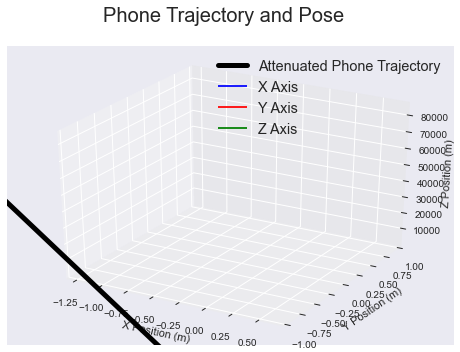

In [53]:
#Quiver Plots to Determine Direction of Phone
#Not necessary but cool

distance = np.sqrt(x[-1]**2 + y[-1]**2 + z[-1]**2)
length = 0.05*distance

final, ax4 = plt.subplots()
final.suptitle('Phone Trajectory and Pose', fontsize=20)
ax4 = plt.axes(projection='3d')
ax4.plot3D(x,y,z, 'k', lw=5, label= 'Attenuated Phone Trajectory')

ax4.quiver(x[::10], y[::10], z[::10], 
           bodyX[0][::10], bodyX[1][::10], bodyX[2][::10], 
           color = 'b', label = 'X Axis', length=length)

ax4.quiver(x[::10],y[::10],z[::10],
          bodyY[0][::10],bodyY[1][::10],bodyY[2][::10],
          color='r',label = 'Y Axis',length = length)

ax4.quiver(x[::10],y[::10],z[::10],
          bodyZ[0][::10],bodyZ[1][::10],bodyZ[2][::10],
          color='g',label = 'Z Axis',length = length)

ax4.set_xlabel('X Position (m)')
ax4.set_ylabel('Y Position (m)')
ax4.set_zlabel('Z Position (m)')

ax4.set_xlim(-1,1)
ax4.set_ylim(-1,1)
ax4.set_xlim(-1.3, 0.7)

ax4.legend(fontsize='x-large')
plt.show()